In [4]:
## Experiment performed by:
## Arham Jain 23/CS/073

# Spam Classification via Naive Bayes

### Importing Necessary Libraries

In [3]:
%pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 6.5 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
import re
import emoji
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Imporing the Dataset

In [6]:
df = pd.read_csv("spam.csv")
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Exploratory Data Analysis

In [7]:
## Checking the shape of the dataset
df.shape

(5572, 2)

In [8]:
## Checking for null values
df.isnull().sum()

,0
Category,0
Message,0


In [9]:
## Checking for any duplicate rows
df.duplicated().any()

np.True_

In [10]:
df.info

<bound method DataFrame.info of      Category                                            Message
0         ham  Go until jurong point, crazy.. Available only ...
1         ham                      Ok lar... Joking wif u oni...
2        spam  Free entry in 2 a wkly comp to win FA Cup fina...
3         ham  U dun say so early hor... U c already then say...
4         ham  Nah I don't think he goes to usf, he lives aro...
...       ...                                                ...
5567     spam  This is the 2nd time we have tried 2 contact u...
5568      ham               Will ü b going to esplanade fr home?
5569      ham  Pity, * was in mood for that. So...any other s...
5570      ham  The guy did some bitching but I acted like i'd...
5571      ham                         Rofl. Its true to its name

[5572 rows x 2 columns]>

In [11]:
## Eliminating the duplicate rows
df = df.drop_duplicates()

In [12]:
## Confirming the elimination of the duplicate rows
df.duplicated().any()

np.False_

In [13]:
df.describe()

,Category,Message
count,5157,5157
unique,2,5157
top,ham,Rofl. Its true to its name
freq,4516,1


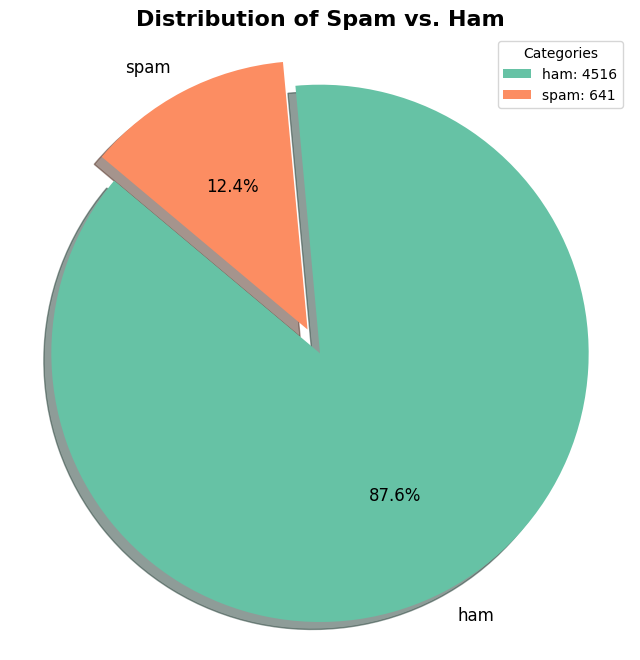

In [14]:
# Calculate the count of each label
category_counts = df['Category'].value_counts()

# Custom colors (seaborn palette)
colors = sns.color_palette("Set2", len(category_counts))

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    category_counts,
    labels=category_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    explode=[0.05] * len(category_counts),  # Slight separation
    shadow=True,
    textprops={'fontsize': 12}
)

plt.title('Distribution of Spam vs. Ham', fontsize=16, fontweight='bold')
plt.axis('equal')  # Ensures a perfect circle
plt.legend(
    [f"{label}: {count}" for label, count in zip(category_counts.index, category_counts)],
    title="Categories",
    loc="upper right",
    fontsize=10
)
plt.show()

### Text Visualisation

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


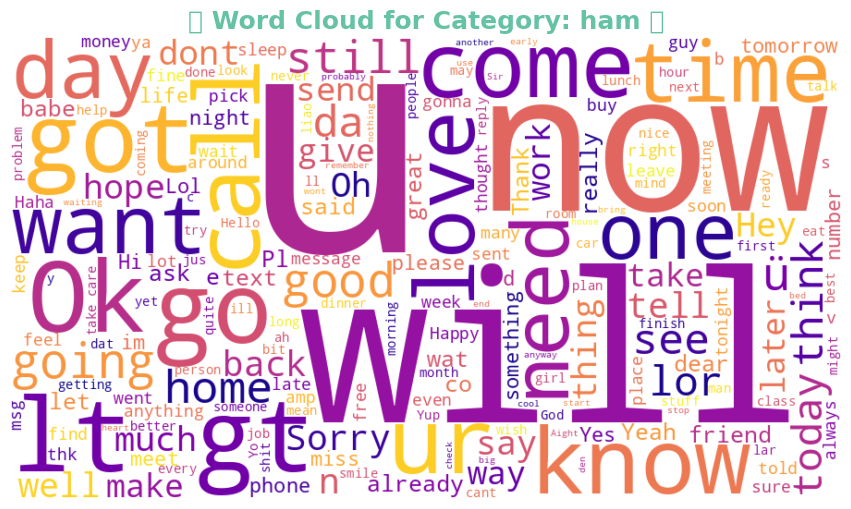

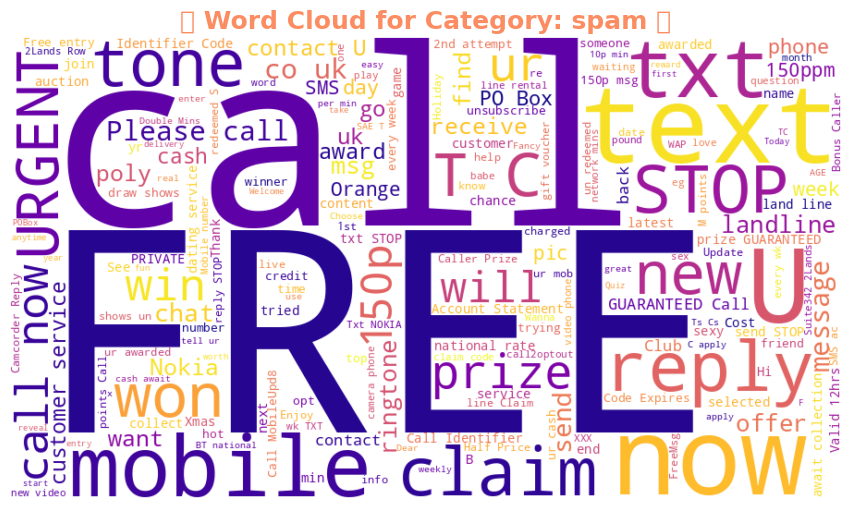

In [15]:
# Custom color palette for categories
palette = sns.color_palette("Set2", len(df['Category'].unique()))
colors = {cat: palette[i] for i, cat in enumerate(df['Category'].unique())}

# Iterate through unique categories
for category in df['Category'].unique():
    # Filter the DataFrame for the current category
    filtered_df = df[df['Category'] == category]

    # Concatenate all text data for the current category
    text = ' '.join(filtered_df['Message'])

    # Generate word cloud
    wordcloud = WordCloud(
        width=900,
        height=500,
        background_color='white',
        colormap='plasma',    # colorful words
        max_words=200,
        contour_color=colors[category],  # border in category color
        contour_width=2
    ).generate(text)

    # Plot the word cloud
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'✨ Word Cloud for Category: {category} ✨',
              fontsize=18, fontweight='bold', color=colors[category])
    plt.axis('off')
    plt.show()

### Encoding

In [16]:
le = LabelEncoder()
df['Category'] = le.fit_transform(df['Category'])

/tmp/ipython-input-3719879376.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Category'] = le.fit_transform(df['Category'])


### Text Preprocessing

We will apply the following operations for the cleaning of the text:

    Lower Casing

    Remove HTML Tags

    Remove URLs

    Replacing Emojis with text description

    Removal of Special Characters (for correct expansion of any chat words)

    Expand Chat Words

    Remove Special Characters (any special characters left)

    Remove Numeric Values

    Handling StopWords

    Normalize white spaces

    Stemming

In [17]:
df["Cleaned_Message"] = df["Message"].str.lower()
df.head()

/tmp/ipython-input-818915510.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Cleaned_Message"] = df["Message"].str.lower()


,Category,Message,Cleaned_Message
0,0,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ..."
1,0,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,0,U dun say so early hor... U c already then say...,u dun say so early hor... u c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro...","nah i don't think he goes to usf, he lives aro..."


In [18]:
from bs4 import BeautifulSoup

In [19]:
# Function to clean text by removing HTML tags, scripts, and styles
def clean_html(text: str) -> str:
    """Remove HTML tags, <script>, and <style> content from text."""
    soup = BeautifulSoup(text, "html.parser")

    # Remove unwanted elements
    for element in soup(["script", "style"]):
        element.extract()

    # Return cleaned text
    return ' '.join(soup.stripped_strings)

# Apply cleaning function to the 'Message' column
df['Message'] = df['Message'].apply(clean_html)


/tmp/ipython-input-1318940597.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Message'] = df['Message'].apply(clean_html)


In [20]:
## Function to remove URLs using regular expressions
def remove_urls(text):
    return re.sub(r"http\S+|www\.\S+", " ", text)

## Apply the function to the "Cleaned_Message" column
df["Cleaned_Message"] = df["Cleaned_Message"].apply(remove_urls)
df.head()

/tmp/ipython-input-2517676817.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Cleaned_Message"] = df["Cleaned_Message"].apply(remove_urls)


,Category,Message,Cleaned_Message
0,0,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ..."
1,0,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,0,U dun say so early hor... U c already then say...,u dun say so early hor... u c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro...","nah i don't think he goes to usf, he lives aro..."


In [21]:
## Function to convert emoji to text descriptions
def replace_emojis(text):
    return emoji.demojize(text, language="en")

## Apply replace_emojis function to "Cleaned_Message" column
df["Cleaned_Message"] = df["Cleaned_Message"].apply(replace_emojis)
df.head()

/tmp/ipython-input-1971490154.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Cleaned_Message"] = df["Cleaned_Message"].apply(replace_emojis)


,Category,Message,Cleaned_Message
0,0,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ..."
1,0,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,0,U dun say so early hor... U c already then say...,u dun say so early hor... u c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro...","nah i don't think he goes to usf, he lives aro..."


In [22]:
## Function to remove the special characters
def remove_special_characters(text):
    return re.sub(r"[^0-9a-zA-Z\s]", " ", text)

## Apply the function to the "Cleaned_Message" column
df["Cleaned_Message"] = df["Cleaned_Message"].apply(remove_special_characters)
df.head()

/tmp/ipython-input-90845697.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Cleaned_Message"] = df["Cleaned_Message"].apply(remove_special_characters)


,Category,Message,Cleaned_Message
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,0,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goes to usf he lives aro...


In [23]:
## Dictionary of chat word mappings
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you",
    "ILU": "I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My Ass Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The Ass",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My Ass Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

In [24]:
## Function to expand the chat words

def replace_chat_words(text):
    words = text.split()  # split text into words
    new_words = []
    for word in words:
        if word.upper() in chat_words:
            new_words.append(chat_words[word.upper()])
        else:
            new_words.append(word)
    return " ".join(new_words)

## Apply replace_chat_words function to "Cleaned_Message" column
df["Cleaned_Message"] = df["Cleaned_Message"].apply(replace_chat_words)
df.head()

/tmp/ipython-input-3706070333.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Cleaned_Message"] = df["Cleaned_Message"].apply(replace_chat_words)


,Category,Message,Cleaned_Message
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif You oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,0,U dun say so early hor... U c already then say...,You dun say so early hor You c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goes to usf he lives arou...


In [25]:
## Function to remove the special characters
def remove_special_characters(text):
    return re.sub(r"[^0-9a-zA-Z\s]", " ", text)

## Apply the function to the "Cleaned_Message" column
df["Cleaned_Message"] = df["Cleaned_Message"].apply(remove_special_characters)
df.head()

/tmp/ipython-input-90845697.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Cleaned_Message"] = df["Cleaned_Message"].apply(remove_special_characters)


,Category,Message,Cleaned_Message
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif You oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,0,U dun say so early hor... U c already then say...,You dun say so early hor You c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goes to usf he lives arou...


In [26]:
## Function to remove the numeric characters
def remove_numeric_characters(text):
    return re.sub(r"\d+", " ", text)

## Apply the function to the "Cleaned_Message" column
df["Cleaned_Message"] = df["Cleaned_Message"].apply(remove_numeric_characters)
df.head()

/tmp/ipython-input-1301415321.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Cleaned_Message"] = df["Cleaned_Message"].apply(remove_numeric_characters)


,Category,Message,Cleaned_Message
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif You oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup fina...
3,0,U dun say so early hor... U c already then say...,You dun say so early hor You c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goes to usf he lives arou...


In [27]:
## Removing the stopwords
all_stop_words = stopwords.words('english')
all_stop_words.remove('not') ## as 'not' is important in classification

## Function to remove the stop words
def remove_stop_words(text):
    words = text.split()
    filtered_words = [word for word in words if(word not in all_stop_words)]
    return " ".join(filtered_words)

## Applying the function to "Cleaned_Message" column
df["Cleaned_Message"] = df["Cleaned_Message"].apply(remove_stop_words)
df.head()

/tmp/ipython-input-1931177921.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Cleaned_Message"] = df["Cleaned_Message"].apply(remove_stop_words)


,Category,Message,Cleaned_Message
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif You oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,0,U dun say so early hor... U c already then say...,You dun say early hor You c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think goes usf lives around though


In [28]:
## Remove extra white spaces from the 'Text' column
def remove_extra_whitespaces(text):
    return re.sub(r"\s+", " ", text).strip()
df["Cleaned_Message"] = df["Cleaned_Message"].apply(remove_extra_whitespaces)
df.head()

/tmp/ipython-input-4172475098.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Cleaned_Message"] = df["Cleaned_Message"].apply(remove_extra_whitespaces)


,Category,Message,Cleaned_Message
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif You oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,0,U dun say so early hor... U c already then say...,You dun say early hor You c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think goes usf lives around though


In [29]:
## Applying stemming
ps = PorterStemmer()

def stem_words(text):
    words = text.split(' ')
    stemmed_words = [ps.stem(word) for word in words]
    return " ".join(stemmed_words)

## Applying the function to "Cleaned_Message" column
df["Cleaned_Message"] = df["Cleaned_Message"].apply(stem_words)
df.head()

/tmp/ipython-input-2435348151.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Cleaned_Message"] = df["Cleaned_Message"].apply(stem_words)


,Category,Message,Cleaned_Message
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,ok lar joke wif you oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkt st m...
3,0,U dun say so early hor... U c already then say...,you dun say earli hor you c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think goe usf live around though


## Implementing Naive Bayes

In [30]:
import numpy as np

class MyNaiveBayes:
    def __init__(self):
        pass

    def fit(self, x_train, y_train, alpha=1):
        """Train Naive Bayes classifier with Laplace smoothing."""
        self.alpha = alpha
        m, self.V = x_train.shape  # m = number of samples, V = vocabulary size

        # Count word occurrences for each class
        self.word_track = np.zeros((2, self.V))
        for i in range(m):
            self.word_track[y_train[i]] += x_train[i]

        # Compute class priors (log form)
        self.class_priors = [
            np.log(np.mean(y_train == 0)),
            np.log(np.mean(y_train == 1))
        ]

    def predict(self, x_test):
        """Predict class labels for given test data."""
        y_pred = []
        sum_0, sum_1 = np.sum(self.word_track[0]), np.sum(self.word_track[1])

        for sentence in x_test:
            # Start with class priors
            class_probab = [self.class_priors[0], self.class_priors[1]]

            # Update with word likelihoods
            for idx, occ in enumerate(sentence):
                if occ > 0:
                    class_probab[0] += occ * np.log((self.alpha + self.word_track[0][idx]) /
                                                    (self.alpha * self.V + sum_0))
                    class_probab[1] += occ * np.log((self.alpha + self.word_track[1][idx]) /
                                                    (self.alpha * self.V + sum_1))

            y_pred.append(np.argmax(class_probab))

        return np.array(y_pred)


### Train Test Split

In [31]:
## We do train–test split before vectorization to prevent data leakage, ensuring the test set words don’t influence the training vocabulary.
x = df["Cleaned_Message"].to_numpy()
y = df["Category"].to_numpy()

In [32]:
x_train, x_test , y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 12)

In [33]:
x_train.shape

(4125,)

In [34]:
x_test.shape

(1032,)

In [35]:
y_train.shape

(4125,)

In [36]:
y_test.shape

(1032,)

## Using CountVectorizer

In [37]:
vectorizer=CountVectorizer()
x_train_vec = vectorizer.fit_transform(x_train).toarray()
x_test_vec = vectorizer.transform(x_test).toarray()

### Comparing performances of different values of alpha


=== Results for α = 0.4 ===
Metric       | Score
-------------------------
Accuracy     | 0.981
Precision    | 0.922
Recall       | 0.922
F1 Score     | 0.922

=== Results for α = 1.5 ===
Metric       | Score
-------------------------
Accuracy     | 0.979
Precision    | 0.927
Recall       | 0.898
F1 Score     | 0.913

=== Results for α = 4.5 ===
Metric       | Score
-------------------------
Accuracy     | 0.978
Precision    | 0.973
Recall       | 0.844
F1 Score     | 0.904


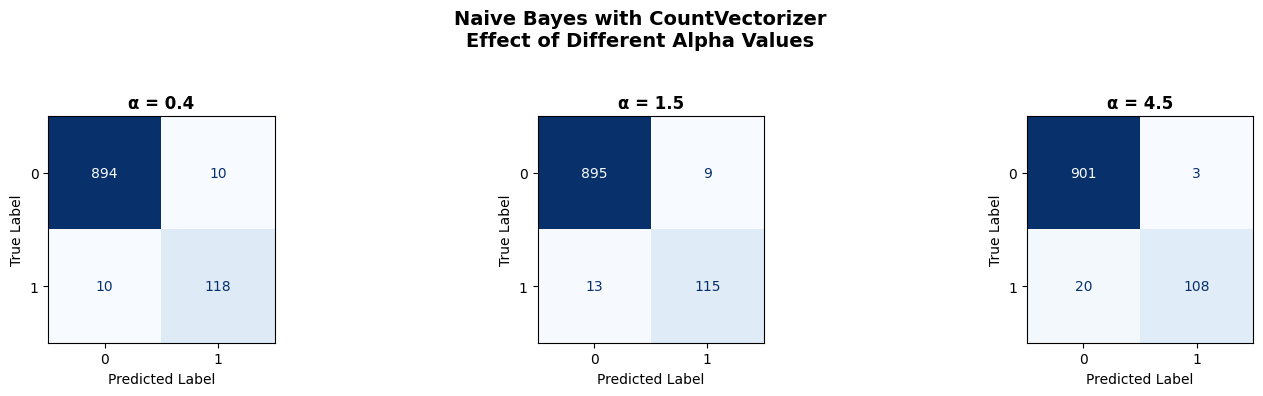

In [38]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, ConfusionMatrixDisplay
)

alphas = [0.4, 1.5, 4.5]

plt.figure(figsize=(15, 4))
plt.suptitle("Naive Bayes with CountVectorizer\nEffect of Different Alpha Values\n", fontsize=14, fontweight="bold")

for i, alpha in enumerate(alphas, start=1):
    # Train model
    model = MyNaiveBayes()
    model.fit(x_train_vec, y_train, alpha=alpha)
    y_pred = model.predict(x_test_vec)

    # Evaluation metrics
    accuracy  = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="binary")
    recall    = recall_score(y_test, y_pred, average="binary")
    f1        = f1_score(y_test, y_pred, average="binary")

    # Pretty print results
    print(f"\n=== Results for α = {alpha} ===")
    print(f"{'Metric':<12} | {'Score'}")
    print("-" * 25)
    print(f"{'Accuracy':<12} | {accuracy:.3f}")
    print(f"{'Precision':<12} | {precision:.3f}")
    print(f"{'Recall':<12} | {recall:.3f}")
    print(f"{'F1 Score':<12} | {f1:.3f}")
    print("=" * 25)

    # Confusion Matrix plot
    cm = confusion_matrix(y_test, y_pred)
    ax = plt.subplot(1, 3, i)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", colorbar=False, ax=ax)
    ax.set_title(f"α = {alpha}", fontsize=12, fontweight="bold")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")

plt.tight_layout()
plt.show()


## Using TfidfVectorizer

In [39]:
vectorizer=TfidfVectorizer()
x_train_vec = vectorizer.fit_transform(x_train).toarray()
x_test_vec = vectorizer.transform(x_test).toarray()

### Comparing performances of different values of alpha


=== Results for α = 0.4 ===
Metric       | Score
-------------------------
Accuracy     | 0.979
Precision    | 0.973
Recall       | 0.852
F1 Score     | 0.908

=== Results for α = 1.5 ===
Metric       | Score
-------------------------
Accuracy     | 0.952
Precision    | 1.000
Recall       | 0.609
F1 Score     | 0.757

=== Results for α = 4.5 ===
Metric       | Score
-------------------------
Accuracy     | 0.898
Precision    | 1.000
Recall       | 0.180
F1 Score     | 0.305


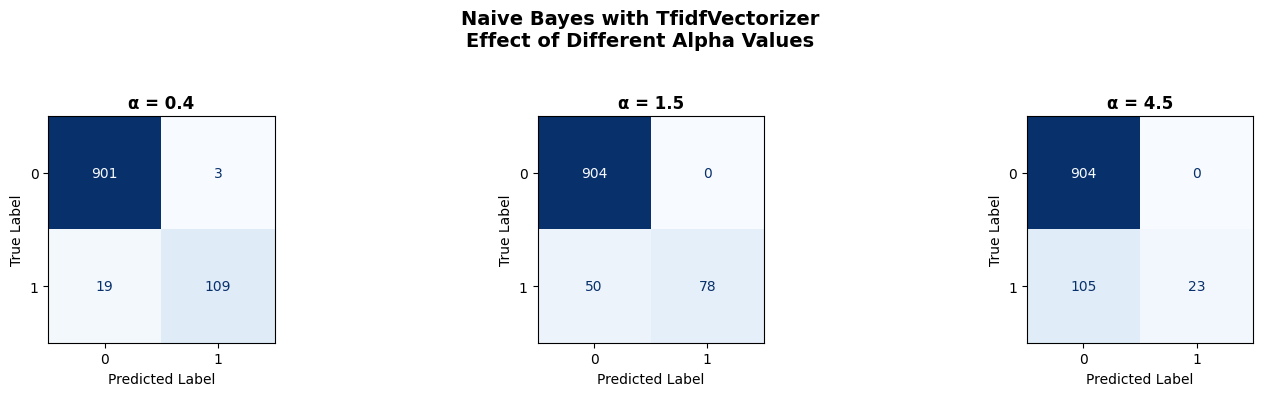

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, ConfusionMatrixDisplay
)

alphas = [0.4, 1.5, 4.5]

plt.figure(figsize=(15, 4))
plt.suptitle("Naive Bayes with TfidfVectorizer\nEffect of Different Alpha Values\n", fontsize=14, fontweight="bold")

for i, alpha in enumerate(alphas, start=1):
    # Train model
    model = MyNaiveBayes()
    model.fit(x_train_vec, y_train, alpha=alpha)
    y_pred = model.predict(x_test_vec)

    # Evaluation metrics
    accuracy  = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="binary")
    recall    = recall_score(y_test, y_pred, average="binary")
    f1        = f1_score(y_test, y_pred, average="binary")

    # Pretty print results
    print(f"\n=== Results for α = {alpha} ===")
    print(f"{'Metric':<12} | {'Score'}")
    print("-" * 25)
    print(f"{'Accuracy':<12} | {accuracy:.3f}")
    print(f"{'Precision':<12} | {precision:.3f}")
    print(f"{'Recall':<12} | {recall:.3f}")
    print(f"{'F1 Score':<12} | {f1:.3f}")
    print("=" * 25)

    # Confusion Matrix plot
    cm = confusion_matrix(y_test, y_pred)
    ax = plt.subplot(1, 3, i)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", colorbar=False, ax=ax)
    ax.set_title(f"α = {alpha}", fontsize=12, fontweight="bold")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")

plt.tight_layout()
plt.show()


## Comparing Logistic Regression with Naive Bayes

In [41]:
results = {
    "Model": ["Logistic Regression", "Logistic Regression", "Naive Bayes", "Naive Bayes"],
    "Vectorizer": ["Count", "TF-IDF", "Count", "TF-IDF"],
    "Reg. λ": [0.1, 0.1, "-", "-"],
    "Accuracy": [0.98, 0.98, 0.98, 0.96],
    "Precision": [0.89, 0.89, 0.92, 1.00],
    "Recall": [0.96, 0.96, 0.94, 0.74],
    "F1": [0.93, 0.93, 0.93, 0.85]
}

df_results = pd.DataFrame(results)
print(df_results)


                 Model Vectorizer Reg. λ  Accuracy  Precision  Recall    F1
0  Logistic Regression      Count    0.1      0.98       0.89    0.96  0.93
1  Logistic Regression     TF-IDF    0.1      0.98       0.89    0.96  0.93
2          Naive Bayes      Count      -      0.98       0.92    0.94  0.93
3          Naive Bayes     TF-IDF      -      0.96       1.00    0.74  0.85
